<a href="https://colab.research.google.com/github/paulhimstedt/CoinCaller/blob/master/CoinCaller_SaschaLingl_PaulHimstedt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Studienleistung 2 IL_2 Sascha Lingl und Paul Himstedt**

## Coin Caller

### Formulierung der Frage bezüglich aktuellen Geschehnissen am Krypto Markt


In [144]:
question_input_string = input("Your Question: ")
print(question_input_string)

Your Question: How is Bitcoin performing
How is Bitcoin performing


### Hier werden die nötigen Installationen und Imports vorgenommen

In [127]:
#First Installation can take up to 5 min
# Install the latest release of Haystack in your own environment 
! pip install farm-haystack

# Install the latest master of Haystack
!pip install git+https://github.com/deepset-ai/haystack.git
!pip install urllib3==1.25.4

#imports
import re
import pandas as pd
import spacy
import tweepy as tw
import os
import datetime
import itertools
from datetime import date
#keys
consumer_key= "TMgCLhdfwOw5TcdqWyPNDqTAs"
consumer_secret= "ATYzvZerlvSd2SsInf9KLtgXAFILm3gXY6Vocj0S77MVM0VvBE"
access_token= "3297798173-zU5fbHhbYWAmGTCCX5loJITmgK19SHkrKxN9aF1"
access_token_secret= "xMYHAIe9D9YZGo8HaRHmIIoNeQg9QHmkENjUIeovdWKVS"

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

# This requires Python’s OS module to create directory
import os.path

# In Colab / No Docker environments: Start Elasticsearch from source
! wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
! tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
! chown -R daemon:daemon elasticsearch-7.9.2

from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.9.2/bin/elasticsearch'],
                   stdout=PIPE, stderr=STDOUT,
                   preexec_fn=lambda: os.setuid(1)  # as daemon
                  )
# wait until ES has started
! sleep 30

# Connect to Elasticsearch

from haystack.document_store.elasticsearch import ElasticsearchDocumentStore
crypto_tweets_document_store = ElasticsearchDocumentStore(host="localhost", username="", password="", index="crypro_tweet_document_store")

#now we preprocess the textual data

from haystack.reader.farm import FARMReader
from haystack.utils import print_answers
from haystack.file_converter import TextConverter
from haystack.preprocessor.utils import convert_files_to_dicts
from haystack.preprocessor.preprocessor import PreProcessor
from haystack.retriever.sparse import ElasticsearchRetriever
from haystack.pipeline import ExtractiveQAPipeline

#Sentiment Search Word prediction Imports
import nltk
from nltk import tokenize
from operator import itemgetter
import math
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')
nltk.download('punkt')

#imports for Sentiment Analysis
import tweepy as tweepy
from textblob import TextBlob, Word, Blobber
from textblob.classifiers import NaiveBayesClassifier
from textblob.taggers import NLTKTagger
import nltk.sentiment
import nltk.sentiment.vader
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

#Creating PieCart
import matplotlib.pyplot as plt

  Cloning https://github.com/deepset-ai/haystack.git to /tmp/pip-req-build-m45nznt4
  Running command git clone -q https://github.com/deepset-ai/haystack.git /tmp/pip-req-build-m45nznt4


09/27/2021 16:55:32 - INFO - elasticsearch -   HEAD http://localhost:9200/ [status:200 request:0.015s]
09/27/2021 16:55:32 - INFO - elasticsearch -   HEAD http://localhost:9200/crypro_tweet_document_store [status:200 request:0.008s]
09/27/2021 16:55:32 - INFO - elasticsearch -   GET http://localhost:9200/crypro_tweet_document_store [status:200 request:0.006s]
09/27/2021 16:55:32 - INFO - elasticsearch -   PUT http://localhost:9200/crypro_tweet_document_store/_mapping [status:200 request:0.034s]
09/27/2021 16:55:32 - INFO - elasticsearch -   HEAD http://localhost:9200/label [status:200 request:0.003s]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Hier wird festgelegt wohin die gesammelten Daten gespeichert werden, Außerdem kann man hier den Umfang der Suche mit den zu durchsuchenden Hastags festlegen

In [87]:
# 'mkdir' creates a directory in current directory.
if(os.path.isdir("/content/tweet_data/") == False):
  os.mkdir('tweet_data')

#define hashtags to search in
altcoins_hashtags_string = ["#bitcoin","#ethereum","#Cardano","#crypto","cryptocurrency","#BinanceCoin",
                          "#Polkadot","#ChainLink","#Solana","#Litecoin","#Polygon"]

### Nun werden basierend auf den Hastags Daten über die Twitter API gefetched

In [91]:
#took 16 min for 51 hashtags
def flatten(t):
    return [item for sublist in t for item in sublist]
date_since = date.today()
print(date_since)
#inspired from https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists

all_user_locs = []
for entries in temp:#cryto_hashtags_string:
  entries+="-filter:verified -filter:links -filter:replies";
  tweets = tw.Cursor(api.search,
              q=entries, 
              lang="en",
              since=date_since).items(1000)

  all_user_locs.append([[tweet.user.screen_name,tweet.user.created_at, tweet.text, tweet.favorite_count, tweet.entities["hashtags"]] for tweet in tweets])
users_locs = flatten(all_user_locs)

print(len(all_user_locs))
print(len(users_locs))

2021-09-27
12
6773


### Hier werden einige Preprocessing Schritte vorgenommen um die manchmal unübersichtlichen Tweets zu säubern. Diese werden dann auch anschließend gespeichert

In [ ]:
tweet_text = pd.DataFrame(data=users_locs, 
                    columns=["name","date", "content", "likes", "hashtags"])
def clean_data():

  #delete links
  tweet_text["content"].replace("((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*", "", regex = True, inplace = True)
                      
  #delete RT Tags
  tweet_text["content"].replace("RT", "", regex = True, inplace = True)

  print(len(tweet_text['content'].tolist()))
  #remove duplicates
  tweet_text.drop_duplicates(subset='content',keep='first', inplace=True)
  print(len(tweet_text['content'].tolist()))  

  #delete formatting
  #Quelle: https://gist.github.com/smram/d6ded3c9028272360eb65bcab564a18a
  tweet_text["content"].replace(to_replace=[r"\t|\n|\r", "\t|\n|\r"], value=["",""], regex=True, inplace=True)

  #delete @names
  tweet_text["content"].replace("@([^\s]*)", "", regex = True, inplace = True)

  #delete hashtags
  #tweet_text["content"].replace("#([^\s]*)", "", regex = True, inplace = True)

  #delete leading whitespaces
  tweet_text["content"].replace(r"^ +| +$", r"", regex=True, inplace=True)

#adds a dot to the end of eachindividual tweet to make it readable as a sentence
def make_tweets_to_sentences(list):
  for tweets in list:
    tweets = tweets+"."
    print(tweets)

clean_data()

content_list = tweet_text['content'].tolist()

# punkte werden hinzugefügt
make_tweets_to_sentences(content_list)
content_list

if((os.path.isfile("/content/tweet_data/tweet_data0.txt") == False)):
  print("doesnt exit")
  with open("tweet_data/tweet_data0.txt", "w") as output:
      output.write(str(content_list))




1724
862
Fear has ruined more wealth than failure ever has. #Bitcoin.
The newly released news of $BBIG short interest being *260%* is setting this week up to be VERY interestingThere will b….
OVERNIGHT UPDATE: #Bitcoin To Become The 21st Century’s Digital Gold, Says Deutsche Bank’s Analyst.
NFT $MATIC drop10,000 will be minted. 1,000 already owned.Everyone who replies, retweet and follows will get a free….
Only encrypt the money you can’t afford to lose. #Bitcoin.
Anyone else feeling a huge pump coming or am I just a permabull that is permabulling pumps into existence? #bitcoinVamos🚀….
What is the best trading platform?#Coinbase #Binance #Bitcoin #bnb #Solana.
I have no doubt #Bitcoin will be worth millions.This is what keeps me buying and stops me from selling!.
Hey there  we'll see you real soon, let's rock!! #Rockstardoge #doge #dogecoin #shibacoin #cryptomemes #to….
Can #Bitcoin get a rally into the weekly close?.
$100k is guaranteed but it was never going to be easy. #Bitcoin.
₿e 

### Hier erstellen wir eine Datei, welche alle bereinigten Tweets umfasst, um das QA-System aufzubauen

In [ ]:
#Now we created a file that contains all the saved tweets, we will build a QA system using Haystack in the following
all_collected_tweets = convert_files_to_dicts(dir_path="tweet_data/")

crypto_tweets_preprocessor = PreProcessor(
    clean_empty_lines=True,
    clean_whitespace=True,
    clean_header_footer=False,
    split_by="sentence", # Dokument wird anhand von Sätzen getrennt
    split_length=10, # Nach 10 Sätzen erfolgt die Trennung -> ein Dokument besteht aus 10 Tweets
    split_overlap = 2, # 2 Sätze Überlappung bei den einzelnen Dokumenten
    split_respect_sentence_boundary=False
)
nested_docs = [crypto_tweets_preprocessor.process(doc) for doc in all_collected_tweets]
crypto_tweet_docs = [doc for x in nested_docs for doc in x]

print(f"n_files_input: {len(all_collected_tweets)}\nn_docs_output: {len(crypto_tweet_docs)}")

09/27/2021 09:48:16 - INFO - haystack.preprocessor.utils -   Converting tweet_data/tweet_data0.txt


n_files_input: 1
n_docs_output: 62


### Jetzt konfigurieren wir den Reader und Retriever unserer Suchmaschiene. Außerdem können wir hier festlegen welches Language Modell verwendet werden soll.

In [ ]:
#Now we configure the reader and retriever
# "ahotrod/albert_xxlargev1_squad2_512"                     bis zu 22min
# "deepset/roberta-base-squad2"                             bis zu 2min
# "deepset/bert-large-uncased-whole-word-masking-squad2"    bis zu 5min
# "deepset/minilm-uncased-squad2"                           unter 1 min

model_name_or_path = "deepset/roberta-base-squad2"
crypto_tweets_document_store.write_documents(crypto_tweet_docs)
crypto_tweet_retriever = ElasticsearchRetriever(document_store=crypto_tweets_document_store)
crypto_tweets_reader = FARMReader(model_name_or_path, use_gpu=True,top_k=10)
crypto_pipe = ExtractiveQAPipeline(crypto_tweets_reader, crypto_tweet_retriever)

09/27/2021 09:49:46 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:0.665s]
09/27/2021 09:49:46 - INFO - farm.utils -   Using device: CPU 
09/27/2021 09:49:46 - INFO - farm.utils -   Number of GPUs: 0
09/27/2021 09:49:46 - INFO - farm.utils -   Distributed Training: False
09/27/2021 09:49:46 - INFO - farm.utils -   Automatic Mixed Precision: None
Some weights of the model checkpoint at deepset/roberta-base-squad2 were not used when initializing RobertaModel: ['qa_outputs.bias', 'qa_outputs.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificat

###Hier werden die Ergebnisse der Suchmaschine angezeigt

In [126]:
crypto_prediction = crypto_pipe.run(query=question_input_string)
print_answers(crypto_prediction, details="minimal")

09/27/2021 15:21:51 - INFO - elasticsearch -   POST http://localhost:9200/crypro_tweet_document_store/_search [status:200 request:0.029s]


show relevant news related to Polkadot


Inferencing Samples: 100%|██████████| 1/1 [00:03<00:00,  3.87s/ Batches]

[   {   'answer': 'Trending Crypto Alert',
        'context': 'ing Polkado now t its like buying KusamaGonna follow '
                   "kusamawhen parachain #Polkadot', 'Trending Crypto Alert!🚨 "
                   '#Polkadot $DOT is trading at USD 29.92.'},
    {   'answer': '#Polkadot is the project that is developing the most',
        'context': 'ot a kid learning ab…", \'Data coming from  shows '
                   '#Polkadot is the project that is developing the most.$DOT '
                   "is in its program to be…', '$DOT is still c"},
    {   'answer': 'Moonbeam, the Ethereum-compatible smart contract',
        'context': "credentials as soon as the…', 'What is Moonbeam ? "
                   '"Moonbeam, the Ethereum-compatible smart contract on a '
                   'Polkadot, is the easiest on-ramp to Polkadot.'},
    {   'answer': 'a protocol that connects blockchains',
        'context': "reat gains along with…', 'What is #Polkadot ?Polkadot is a "
                   

### Hier werden aus der Suchanfrage mögliche Keywords extrahiert um einen Vorschag für die anstehende Sentiment Analyse zu generieren

In [99]:
#arr = question_input_string.split(',')
#print(arr)
def extractKeyword(input):
  arr = input.split()
  keyword_filter =["Bitcoin", "Ethereum","Cardano", "Crypto", "Cryptocurrency", "BinanceCoin", "Polkadot", "ChainLink", "Solana", "Litecoin", "Polygon", "Tether", "Monero", "Stellar", "Pancakeswap"];
  for x in arr:
    for y in keyword_filter:
      if(x == y):
        return y;
  return input;

### Hier wird am Ende noch ein Sentiment Diagramm zu dem eingegebenen Suchbegriff erzeugt

Please enter keyword or hashtag to search: (Recommended: Polkadot ) Uniswap
Please enter how many tweets to analyze: (Recommended: 500 ) 1000
total number:  1000
positive number:  472
negative number:  44
neutral number:  484


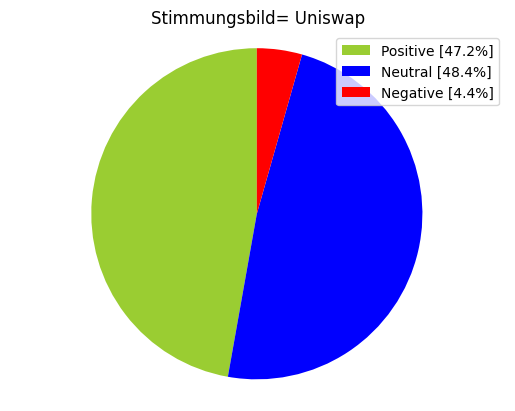

In [139]:

def percentage(part,whole):
    return 100 * float(part)/float(whole) 

suggestions = extractKeyword(question_input_string);

keyword = input("Please enter keyword or hashtag to search: (Recommended: "+suggestions+" ) ")
noOfTweet = int(input ("Please enter how many tweets to analyze: (Recommended: 500 ) "))

tweets = tweepy.Cursor(api.search, q=keyword).items(noOfTweet)
positive  = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []

for tweet in tweets:
    
    tweet_list.append(tweet.text)
    analysis = TextBlob(tweet.text)
    score = sid.polarity_scores(tweet.text)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity
  
    if neg > pos:
        negative_list.append(tweet.text)
        negative += 1

    elif pos > neg:
        positive_list.append(tweet.text)
        positive += 1
    
    elif pos == neg:
        neutral_list.append(tweet.text)
        neutral += 1

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print("total number: ",len(tweet_list))
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))
print("neutral number: ",len(neutral_list))

labels = ["Positive ["+positive+"%]" , "Neutral ["+neutral+"%]","Negative ["+negative+"%]"]
sizes = [positive, neutral, negative]
colors = ["yellowgreen", "blue","red"]
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use("default")
plt.legend(labels)
plt.title("Stimmungsbild= "+keyword+"" )
plt.axis("equal")
plt.show()